In [1]:
import pandas as pd
import numpy as np
import scipy
import math

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.decomposition import PCA

from sklearn.utils import check_random_state

import lime
import lime.lime_tabular

from sksurv.nonparametric import CensoringDistributionEstimator, kaplan_meier_estimator

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D

from ClusterZipCodes import ClusterZipCodes
from PrepareData import PrepareData
from HyperparameterSearch import unoC, gb_paramsearch

import gc
import time

DATAPATH     = ""
DISTANCEPATH = ""
ZIPPATH      = ""

# Step 0: Prepare data

In [2]:
dt    = PrepareData(DATAPATH, ZIPPATH)
train = dt["Train"]
val   = dt["Val"]
test  = dt["Test"]

dtzip = dt["Zips"]

Prevalence:  0.07720911006062123
Number of ZIP codes: 14247
True
0.0771144076379115
0.07711520579183917
0.07711392874489222


# Step 1: Zip codes

## 1.0 Compute the first three digits of each zip code


In [39]:
train["Zipcode_3"] = train.Zipcode_5.apply(lambda x: x[:3]) 
val["Zipcode_3"]   = val.Zipcode_5.apply(  lambda x: x[:3]) 
test["Zipcode_3"]  = test.Zipcode_5.apply( lambda x: x[:3]) 

train_zips = pd.get_dummies(train["Zipcode_3"], prefix = "ZipDigits")
val_zips   = pd.get_dummies(val["Zipcode_3"],   prefix = "ZipDigits")
test_zips  = pd.get_dummies(test["Zipcode_3"],  prefix = "ZipDigits")

train = pd.concat([train.reset_index(drop=True), train_zips], axis=1)
val   = pd.concat([val.reset_index(drop=True), val_zips], axis=1)
test  = pd.concat([test.reset_index(drop=True), test_zips], axis=1)

## 1.1 Cluster zip codes 

- Draw the KM survival curve for each zip code 
- Compute pairwise log-rank statistic between all zip codes
- Use these pairwise distances to perform clustering using k-medioids

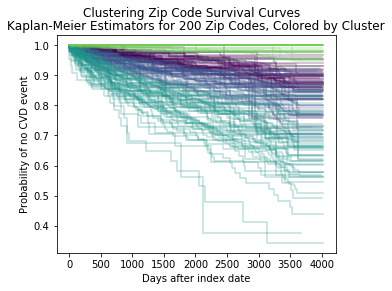

In [4]:
clusters = ClusterZipCodes(train, 4, distances_path = DISTANCEPATH)

clusts   = clusters["Clusters"]
meds     = clusters["Medians"]
kms      = clusters["KMs"]
all_zips = clusters["AllZips"]

colors = cm.get_cmap('viridis', 24)
plt.figure(figsize=(5,4))
for i, l in enumerate(meds):
    count = len(np.where(clusts == l)[0])
    for _ in range(min(50, count)):
        t = np.random.randint(0, count)
        plt.step(
            kms.loc[all_zips[np.where(clusts == l)[0][t]]][["DaysToEventOrCensoring", "St"]].sort_values(by="DaysToEventOrCensoring").DaysToEventOrCensoring,
            kms.loc[all_zips[np.where(clusts == l)[0][t]]][["DaysToEventOrCensoring", "St"]].sort_values(by="DaysToEventOrCensoring").St,
            color = colors(1 - (4-i)/4),
            alpha=.3
        )
        
plt.suptitle("Clustering Zip Code Survival Curves")
plt.title("Kaplan-Meier Estimators for 200 Zip Codes, Colored by Cluster")
plt.xlabel("Days after index date")
plt.ylabel("Probability of no CVD event")

In [5]:
clusters = pd.DataFrame({"Zipcode_5" : all_zips, "Cluster": clusts})

train = train.merge(clusters, left_on = "Zipcode_5", right_on = "Zipcode_5")
val   = val.merge(  clusters, left_on = "Zipcode_5", right_on = "Zipcode_5")
test  = test.merge( clusters, left_on = "Zipcode_5", right_on = "Zipcode_5")

for i in meds:
    cname = 'cluster_' + str(i)
    train[cname] = val[cname] = test[cname] = 0 
    train.loc[train.Cluster == i, cname] = 1
    val.loc[  val.Cluster == i,   cname] = 1
    test.loc[ test.Cluster == i,  cname] = 1

## 1.2 Compute PCA on zip codes
- Standardize the census data.
- Perform PCA
- Project zip codes onto the PC features, and include in our train/val/test datasets.

In [6]:
pca_cols = [x for x in dtzip.columns if x not in ["Zip", "unique_zip", "grouped_zip"]]

pca_scaler    = preprocessing.StandardScaler()
dtzip_for_pca = pca_scaler.fit_transform(dtzip[pca_cols])

zip_pca = PCA()
pca_mapped = zip_pca.fit_transform(dtzip[pca_cols])

# We find that 20 PCs covers most of the variance:
np.cumsum(zip_pca.explained_variance_ratio_)[20]

0.9991216716495603

In [7]:
# Append our new columns to our data frames:
for i in range(21):
    dtzip["PC_" + str(i)] = pca_mapped[:, i]
    
train = train.merge(dtzip[["grouped_zip"] + ["PC_" + str(i) for i in range(21)]], 
                           left_on = "Zipcode_5", 
                           right_on = "grouped_zip"
                    )

val = val.merge(dtzip[["grouped_zip"] + ["PC_" + str(i) for i in range(21)]], 
                           left_on = "Zipcode_5", 
                           right_on = "grouped_zip"
                    )

test = test.merge(dtzip[["grouped_zip"] + ["PC_" + str(i) for i in range(21)]], 
                           left_on = "Zipcode_5", 
                           right_on = "grouped_zip"
                    )


# Step 2: Predict censoring for IPW weighting
- Compute KM estimates for data in each zip code.
- Make a new column with the IPCW weight for each row in our train/val/test datasets.

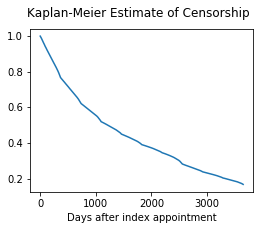

In [8]:
time, prob = kaplan_meier_estimator(
        [x == 1 for x in train.Censored.values],
        train.DaysToEventOrCensoring
)

censoring_kms = pd.DataFrame({"DaysToEventOrCensoring": time, "KM": prob})

train = train.merge(censoring_kms)
val   = val.merge(censoring_kms)
test  = test.merge(censoring_kms)

train["IPCW"] = 1/train.KM
val["IPCW"]   = 1/val.KM
test["IPCW"]  = 1/test.KM

plt.figure(figsize=(4, 3))
plt.plot(censoring_kms[censoring_kms.DaysToEventOrCensoring <= 365*10].DaysToEventOrCensoring, 
         censoring_kms[censoring_kms.DaysToEventOrCensoring <= 365*10].KM)
plt.suptitle("Kaplan-Meier Estimate of Censorship");
plt.xlabel("Days after index appointment");

# Step 3: Model CVD
- Define columns/standardize age.
- Define groups of columns to use, and run the hyperparameter search.

In [9]:
# Determine the feature sets we will model
cols = [
            'Gdr_M', 'Tobacco', 'StandardizedAgeIn2007',
            'CKD', 'RA','DiabetesT1', 'DiabetesT2', 'Hypercholesterolemia', 'Hypertension',
            'Hyperlipidemia', 'Tobacco', 'Insulin', 'Statin', 'Sulfonylureas',
            'Thiazolidinediones', 'ACEInhibitor', 'BBlocker', 'ABlocker',
            'Dihydropyridines', 'Antiinflammatory', 'Antiinflammatory2',
            'Biguanides', 'CalciumChannelBlockers', 'LoopDiuretics',
            'AntiCoagulants', 'CholesterolAbsorptionInhibitors', 'NitrateNitrite',
            'Cardiotonic', 'Dialysis'
]

zip_clusters = [x for x in train.columns if "cluster_" in x]
zip_pca      = [x for x in train.columns if "PC_" in x]
zip_digs     = [x for x in train.columns if "ZipDigits" in x]

tra_ix = train.Censored == 0
val_ix = val.Censored == 0
tst_ix = test.Censored == 0

scaler = preprocessing.StandardScaler().fit(train[["AgeIn2007"]])
train["StandardizedAgeIn2007"] = scaler.transform(train[["AgeIn2007"]]).reshape(-1)
val["StandardizedAgeIn2007"]   = scaler.transform(val[["AgeIn2007"]]).reshape(-1)
test["StandardizedAgeIn2007"]  = scaler.transform(test[["AgeIn2007"]]).reshape(-1)

In [ ]:
# Perform our hyperparameter search for GBTrees:
def get_dataset(dataset):
    if dataset == "train":
        return(train)
    else:
        return(val)

COLUMNS  = [[], zip_clusters, zip_pca, zip_digs]
COLNAMES = ["no_zip", "zip_clusters", "zip_pca", "zip_digs"] 

for DEPTH in [5]:
    for i in range(len(COLNAMES)):
        print(COLNAMES[i])
        t0 = time.time()
        gb_paramsearch(DEPTH, cols + COLUMNS[i] , COLNAMES[i])
        print(time.time() - t0)

# Step 4: Choose hyperparameters.
- We visualize the data frame written by our hyperparameter search.

Text(0.5, 1.0, 'Performance Metrics vs Number of Trees')

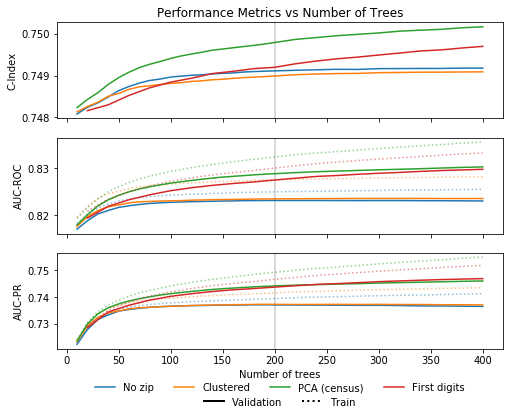

In [23]:
modelmetrics = pd.read_csv("./Performance_Metrics/metric_df.csv")

fig, ax1 = plt.subplots(3, 1, figsize=(8,6), sharey=False, sharex=True)
ax11, ax12, ax13 = ax1
prettymetric = {"no_zip": "No zip", "zip_clusters":"Clustered", "zip_pca":"PCA (census)", 
                "zip_digs":"First digits"}
labels = {"unoC": "C-Index", "aucROC":"AUC-ROC", "aucPR":"AUC-PR"}

treemax = 400
for ax, m in zip([ax11, ax12, ax13], ["unoC", "aucROC", "aucPR"]):
    depth = 5
    for i, col in enumerate(['no_zip', 'zip_clusters', 'zip_pca', 'zip_digs']):
        subset = modelmetrics
        subset = subset[(subset.depth == depth) & (subset.trees <= treemax) & (subset.cols == col)]
        
        ax.axvline(200, color = 'k', alpha=.05)
        ax.plot(subset.trees,
                 subset[m + "_val"],
                 label = prettymetric[col],
                 color = 'C' + str(i)
        )
        if m != "unoC":
            ax.plot(subset.trees,
                     subset[m + "_train"],
                     linestyle = ":",
                     alpha=.5,
                     color = 'C' + str(i)
            )
        
        ax.set_ylabel(labels[m])

plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.55), frameon=False)

ls = ["-", ":"]
lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=l) for l in ls]
labels = ['Validation', 'Train']
leg = Legend(ax13, lines, labels, ncol=2, loc='lower center', bbox_to_anchor= (.5, -.7), frameon=False)
fig.add_artist(leg)

ax.set_xlabel("Number of trees")
ax11.set_title("Performance Metrics vs Number of Trees")

# Step 5: Record predictions for our best models.
- Having chosen hyperparameters, we record the predictions for each of our best models.

In [47]:
# First, we build models on our train and validation data,
# then we predict on all data (train, val and test).
# We write each model's predictions to a csv for later use.
def get_results_and_write(cols_to_use, cname):
    lr = LogisticRegression(penalty = 'l1')
    lr.fit( 
        final_train_data.loc[final_train_ix, cols_to_use], 
        final_train_data.loc[final_train_ix, "AnyOutcome"], 
        sample_weight = final_train_data.loc[final_train_ix, "IPCW"]
    )

    gb = GradientBoostingClassifier(
            random_state=0, 
            verbose = True,
            min_samples_leaf = 5,
            max_depth = 5,
            n_estimators = 200,
            subsample = 1,
            learning_rate=0.1
    )
    gb.fit(
          final_train_data.loc[final_train_ix, cols_to_use], 
          final_train_data.loc[final_train_ix, "AnyOutcome"], 
          sample_weight = final_train_data.loc[final_train_ix, "IPCW"]
    )
    
    print("Predicting etc. on train data")
    
    final_train_data["LR_Pred_" + cname] = lr.predict_proba(final_train_data[cols_to_use ])[:, 1]
    final_train_data["GB_Pred_" + cname] =  gb.predict_proba(final_train_data[cols_to_use ])[:, 1]
    print("Writing to csv.")
    
    final_train_data[["LR_Pred_" + cname, "GB_Pred_" + cname]].to_csv("./TrainVal_" + cname + "Preds.csv", index=False)
    
    print("Predicting etc. on test data")
    
    final_test_data["LR_Pred_" + cname] = lr.predict_proba(final_test_data[cols_to_use ])[:, 1]
    final_test_data["GB_Pred_" + cname] =  gb.predict_proba(final_test_data[cols_to_use ])[:, 1]
    print("Writing to csv.")
    final_test_data[["LR_Pred_" + cname, "GB_Pred_" + cname]].to_csv("./Test_" + cname + "Preds.csv", index=False)

In [ ]:
get_results_and_write(cols, "NoZip") 
get_results_and_write(cols + zip_pca, "Zip_PCA")
get_results_and_write(cols + zip_clusters, "Zip_Clusters")
get_results_and_write(cols + zip_digs, "Zip_Digits")

In [ ]:
train_nozip = pd.read_csv("./TrainVal_NoZipPreds.csv")
test_nozip  = pd.read_csv("./TestVal_NoZipPreds.csv")

for c in train_nozip.columns:
    train[c] =  train_nozip[c]
    test[c] =  test_nozip[c]   

train_pca   = pd.read_csv("./TrainVal_Zip_PCAPreds.csv")
test_pca    = pd.read_csv("./Test_Zip_PCAPreds.csv")

for c in train_pca.columns:
    train[c] =  train_pca[c]
    test[c] =  test_pca[c]

train_clu = pd.read_csv("./TrainVal_Zip_ClustersPreds.csv")
test_clu  = pd.read_csv("./Test_Zip_ClustersPreds.csv")

for c in train_clu.columns:
    train[c] =  train_clu[c]
    test[c] =  test_clu[c]
    
train_dig = pd.read_csv("./TrainVal_Zip_DigitsPreds.csv")
test_dig  = pd.read_csv("./Test_Zip_DigitsPreds.csv")

for c in train_dig.columns:
    train[c] =  train_dig[c]
    test[c] =  test_dig[c]

# Step 6: Performance metrics

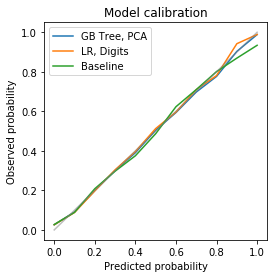

In [30]:
test_resampled = test[test.Censored == 0]
test_resampled = test_resampled.sample(len(test), weights = "IPCW", replace=True)

def bin_stat(x, col):
    in_bin = test_resampled.AnyOutcome[(test_resampled[col] >= x - .05) & (test_resampled[col] < x + .05)]
    if len(in_bin) == 0:
        return(0)
    return(sum(in_bin)/len(in_bin))

fig, ax = plt.subplots(figsize=(4,4))

calibration_gb = [bin_stat(x/10, "GB_Pred_Zip_PCA") for x in range(11)]
ax.plot([y/10 for y in range(11)], calibration_gb, label = "GB Tree, PCA")

calibration_gb = [bin_stat(x/10, "GB_Pred_Zip_Digits") for x in range(11)]
ax.plot([y/10 for y in range(11)], calibration_gb, label = "LR, Digits")

calibration_gb = [bin_stat(x/10, "LR_Pred_NoZip") for x in range(11)]
ax.plot([y/10 for y in range(11)], calibration_gb, label = "Baseline")
(lambda x: plt.plot(x, x, color='gray', alpha=.5))([y/10 for y in range(11)])

plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Model calibration")
plt.legend() 

plt.show()

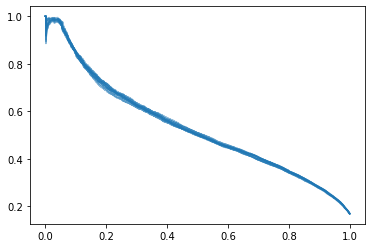

In [35]:
precs = []
recs  = []

fully_observed_test = test[test.Censored == 0]
for i in range(20):
    test_resampled = fully_observed_test.sample(len(fully_observed_test), weights = "IPCW", replace=True)
    
    column = "GB_Pred_Zip_PCA"
    
    p, r, _ = metrics.precision_recall_curve(test_resampled.AnyOutcome, test_resampled[column]) 
    precs.append(p)
    recs.append(r)
    
for t in range(10):
    plt.plot(recs[t], precs[t], color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0], alpha=.5)